In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from random import shuffle

In [2]:
TRAIN_DIR = '../input/train/'
TRAIN_DIR_DOG = '../input/train/dog/' 
TRAIN_DIR_CAT = '../input/train/cat/'

VAL_DIR = '../input/validation/'
VAL_DIR_DOG = '../input/validation/dog/'
VAL_DIR_CAT = '../input/validation/cat/'

TEST_DIR = '../input/test/'

ROWS = 128
COLS = 128
CHANNELS = 1
TOTAL_COUNT = 12500
TRAIN_COUNT = int(TOTAL_COUNT*0.75)
VAL_COUNT = int(TOTAL_COUNT*0.25)

RETRAIN = True

data_dict = {}

dog_train_list = [TRAIN_DIR_DOG+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_DOG))]
cat_train_list = [TRAIN_DIR_CAT+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_CAT))]

data_dict['train_data_files'] = dog_train_list + cat_train_list
data_dict['train_labels'] = [1]*TRAIN_COUNT + [0]*TRAIN_COUNT

dog_val_list = [VAL_DIR_DOG+name for i, name in \
                enumerate(os.listdir(VAL_DIR_DOG))]
cat_val_list = [VAL_DIR_CAT+name for i, name in \
                enumerate(os.listdir(VAL_DIR_CAT))]

data_dict['val_data_files'] = dog_val_list + cat_val_list
data_dict['val_labels']= [1]*VAL_COUNT + [0]*VAL_COUNT
          
print(len(data_dict['train_data_files']))
print(len(data_dict['val_data_files']))


18750
6250


In [3]:
def load_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#     b,g,r = cv2.split(img)
#     rgb_img = cv2.merge([r,g,b])
    return cv2.resize(img, (ROWS,COLS))
    

def load_image_list(file_list):
    count = len(file_list)
    data = np.ndarray((count, ROWS, COLS, CHANNELS),\
                      dtype=np.uint8)
    for i, image_name in tqdm(enumerate(file_list)):
        data[i] = np.expand_dims(load_image(image_name), axis=2)
    return data / 255.0

   
data_dict['train_data'] = load_image_list(\
                            data_dict['train_data_files'])
data_dict['val_data'] = load_image_list(\
                            data_dict['val_data_files'])
print(data_dict['val_data'].shape)

18750it [00:43, 427.51it/s]
6250it [00:14, 423.77it/s]


(6250, 128, 128, 1)


In [4]:
data_dict['all_data'] = np.concatenate((data_dict['train_data'], data_dict['val_data']), axis=0)
data_dict['all_labels'] = data_dict['train_labels'] + data_dict['val_labels']

data_dict['all_data'].shape


(25000, 128, 128, 1)

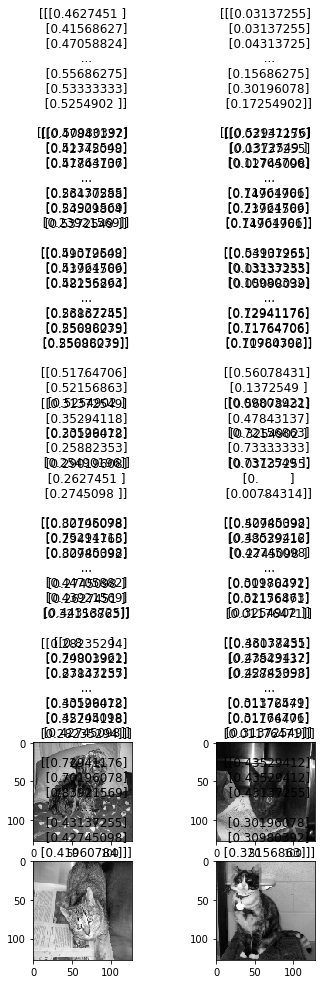

In [5]:
f, axarr = plt.subplots(2,2)
axarr[0,0].set_title(data_dict['all_data'][0])
axarr[0,0].imshow(np.squeeze(data_dict['all_data'][0], axis=2), cmap='gray')

axarr[1,0].set_title(data_dict['all_data'][TOTAL_COUNT-1])
axarr[1,0].imshow(np.squeeze(data_dict['all_data'][TOTAL_COUNT-1]), cmap='gray')

axarr[0,1].set_title(data_dict['all_data'][TOTAL_COUNT])
axarr[0,1].imshow(np.squeeze(data_dict['all_data'][TOTAL_COUNT]), cmap='gray')

axarr[1,1].set_title(data_dict['all_data'][TOTAL_COUNT*2 -1])
axarr[1,1].imshow(np.squeeze(data_dict['all_data'][TOTAL_COUNT*2 -1]), cmap='gray')
plt.show()

In [6]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(4,4),\
                 padding='Same', activation='relu',\
                 input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=8, kernel_size=(4,4),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=16, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8**2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = SGD(lr=0.03)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       68        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        8208      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [7]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

filepath='cat_dog_v4a1'

if RETRAIN:
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=5)

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
                                 mode='min')

    epochs = 160
#     history = model.fit(x=data_dict['train_data'],
#                         y=data_dict['train_labels'],
#                         batch_size=32,
#                         epochs=epochs,
#                         verbose=2,
#                         shuffle=True,
#                         validation_data=(data_dict['val_data'],
#                                          data_dict['val_labels']),
#                         callbacks=[early_stop, checkpoint])
    history = model.fit(x=data_dict['all_data'],
                        y=data_dict['all_labels'],
                        batch_size=32,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        validation_split=0.4,
                        callbacks=[early_stop, checkpoint])

elif filepath in os.listdir():
    print('Loading model from disk..')
    model = load_model(filepath)

Train on 15000 samples, validate on 10000 samples
Epoch 1/160
 - 247s - loss: 0.6537 - acc: 0.6234 - val_loss: 0.7234 - val_acc: 0.3125

Epoch 00001: saving model to cat_dog_v4a1
Epoch 2/160
 - 14s - loss: 0.6417 - acc: 0.6265 - val_loss: 0.7286 - val_acc: 0.3615

Epoch 00002: saving model to cat_dog_v4a1
Epoch 3/160
 - 14s - loss: 0.6265 - acc: 0.6344 - val_loss: 0.7559 - val_acc: 0.3928

Epoch 00003: saving model to cat_dog_v4a1
Epoch 4/160
 - 14s - loss: 0.6167 - acc: 0.6434 - val_loss: 0.7058 - val_acc: 0.4949

Epoch 00004: saving model to cat_dog_v4a1
Epoch 5/160
 - 14s - loss: 0.6053 - acc: 0.6576 - val_loss: 0.7148 - val_acc: 0.5267

Epoch 00005: saving model to cat_dog_v4a1
Epoch 6/160
 - 14s - loss: 0.5815 - acc: 0.6843 - val_loss: 0.6315 - val_acc: 0.6636

Epoch 00006: saving model to cat_dog_v4a1
Epoch 7/160
 - 14s - loss: 0.5640 - acc: 0.7030 - val_loss: 0.6764 - val_acc: 0.6032

Epoch 00007: saving model to cat_dog_v4a1
Epoch 8/160
 - 14s - loss: 0.5423 - acc: 0.7209 - val

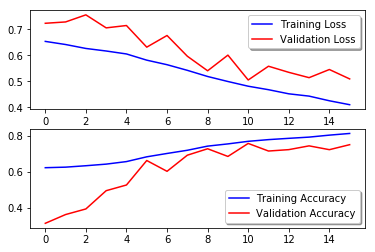

In [8]:
fig, ax = plt.subplots(2,1)
# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

In [9]:
test_image_list = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

with open('submission_file2.csv','w') as f:
    f.write('id,label\n')
with open('submission_file2.csv','a') as f:
    test_set = load_image_list(test_image_list)
    print('Evaluate the test set..')
    prediction = model.predict(test_set)
    print('Writing the prediction in the submition file..')
    for i, image_file in tqdm(enumerate(prediction)):
        f.write('{},{}\n'.format(i+1, prediction[i][0]))

12500it [00:28, 441.89it/s]


Evaluate the test set..
Writing the prediction in the submition file..


12500it [00:00, 150704.67it/s]
